In [248]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scout import utils
from scout import io

In [249]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/'
os.listdir(working_dir)

['example_roi_Artifacts.pdf',
 'TBR1_microenvironment_TBR1adj.pdf',
 'example_roi_Adjacent.pdf',
 'umap_d35_vs_d60.pdf',
 'feature_correlation_graph.html',
 'volcano_d35_d60.pdf',
 'feature_correlation_graph_0_75_labels.html',
 'average_profile_TBR1-LowDN.pdf',
 'example_slices.pdf',
 'average_profile_TBR1-HighDN.pdf',
 'example_roi_Surface.pdf',
 'clustermap_d35_d60_hits.pdf',
 'Lancaster_d60',
 'TBR1_microenvironment_gate_TBR1adj.pdf',
 'relative_stderr_plot.pdf',
 'example_roi_DN.pdf',
 'cyto_profiles_combined.npy',
 'SOX2_microenvironment_TBR1prox_sort.pdf',
 'feature_correlation_graph_0_8_nolabels.html',
 'feature_correlation_graph_0_6.html',
 'average_profile_DN.pdf',
 'feature_correlation_graph_0_7.html',
 'feature_correlation_graph_0_8.html',
 'analysis.csv',
 'pseudoslice_2d_vs_3d_dist.pdf',
 'cyto_clusters_umap.pdf',
 'SOX2_microenvironment_gate_SOX2adj.png',
 'average_profile_Artifacts.pdf',
 'feature_correlation_graph_0_75_nolabels.html',
 'model_d35_d60.umap',
 'average_pr

In [250]:
analysis = pd.read_csv(os.path.join(working_dir, 'analysis.csv'), index_col=0)
analysis.head()

type
path                                                             
20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60  Lancaster_d35
20190419_15_50_16_AA_org2_488LP13_561LP120_642LP60  Lancaster_d35
20190419_16_09_03_AA_org3_488LP13_561LP120_642LP60  Lancaster_d35
20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561...  Lancaster_d35
20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP...  Lancaster_d35

Get centroids, labels, and proximities from an example Zika and Mock organoid

In [251]:
orgs = analysis.where(analysis['type'] == 'Lancaster_d35').dropna()

len(orgs)

12

In [252]:
org_idx = 1

org = orgs.iloc[org_idx]
org_path = os.path.join(working_dir, org['type'], orgs.index[org_idx])
org_path

'/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_15_50_16_AA_org2_488LP13_561LP120_642LP60'

In [253]:
centroids = np.load(os.path.join(org_path, 'dataset/centroids.npy'))
centroids.shape

(1130499, 3)

In [254]:
labels = np.load(os.path.join(org_path, 'dataset/nuclei_gating.npy'))
labels.shape

(1130499, 2)

In [255]:
proximities = np.load(os.path.join(org_path, 'dataset/niche_proximities.npy'))
proximities.shape

(1130499, 2)

In [256]:
utils.read_csv(os.path.join(org_path, 'dataset/celltype_names.csv'))

['sox2', 'tbr1', 'dn']

Extract all TBR1+ proximities

In [257]:
# idx_tbr1 = np.where(labels[:, 1] == 1)[0]
idx_tbr1 = np.where(np.logical_and(labels[:, 1] == 1, labels[:, 0] == 0))[0]

prox_tbr1 = proximities[idx_tbr1]

prox_tbr1.shape

(164484, 2)

In [258]:
%matplotlib inline

In [259]:
from scipy.stats import gaussian_kde
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp2d

In [260]:
n_cells = 10_000
grid_size = 100

prox_tbr1_kde = prox_tbr1[np.random.choice(np.arange(len(prox_tbr1)), n_points)].T
kernel = gaussian_kde(prox_tbr1_kde)
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
Z.shape

(100, 100)

In [261]:
f = RegularGridInterpolator(2*(np.linspace(0, 1, 100),), Z)
f

In [262]:
z = f(prox_tbr1)
z.shape

(164484,)

In [263]:
z.max(), z.min()

(25.865554009204097, 5.303772294885688e-20)

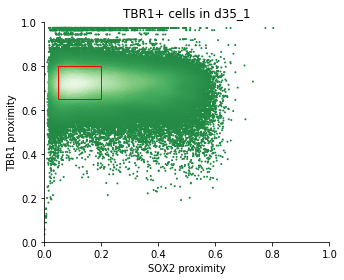

In [264]:
start = np.asarray([0.05, 0.65])
stop = np.asarray([0.2, 0.8])

c = -np.log(z+1e2)

plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(prox_tbr1[:, 0], prox_tbr1[:, 1], s=1, c=c, edgecolor=None, cmap='Greens', vmin=np.percentile(c, 0)-0.03, vmax=np.percentile(c, 100)+0.08)
rect = Rectangle(start, stop[0]-start[0], stop[1]-start[1], edgecolor='r', linewidth=1, fill=False)
ax1.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'TBR1+ cells in d35_{org_idx}')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
plt.tight_layout()
sns.despine()
plt.show()

In [265]:
def show_gate(start, stop):
    c = -np.log(z+1e2)
    
    plt.figure(figsize=(9, 4))
    ax1 = plt.subplot(1, 2, 1)
    plt.scatter(prox_tbr1[:, 0], prox_tbr1[:, 1], s=1, c=c, edgecolor=None, cmap='Greens', vmin=np.percentile(c, 0)-0.03, vmax=np.percentile(c, 100)+0.08)
    rect = Rectangle(start, stop[0]-start[0], stop[1]-start[1], edgecolor='r', linewidth=1, fill=False)
    ax1.add_patch(rect)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(f'TBR1+ cells in d35_{org_idx}')
    plt.xlabel('SOX2 proximity')
    plt.ylabel('TBR1 proximity')
    sns.despine()
    plt.tight_layout()

In [266]:
def apply_gate(start, stop, prox):
    cond0 = np.logical_and(prox[:, 0] > start[0], prox[:, 0] < stop[0])
    cond1 = np.logical_and(prox[:, 1] > start[1], prox[:, 1] < stop[1])
    idx = np.where(np.logical_and(cond0, cond1))[0]
    return prox[idx], idx

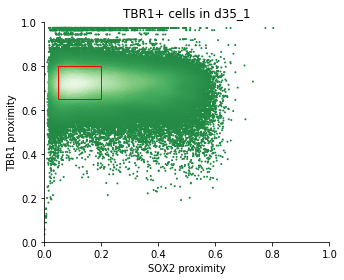

((65062, 2), (65062,), 65062, 0.39555215096909124)

In [269]:
start = np.asarray([0.05, 0.65])
stop = np.asarray([0.2, 0.8])

show_gate(start, stop)
# plt.savefig(os.path.join(working_dir, 'TBR1_microenvironment_gate_TBR1adj.png'), bbox_inches='tight')
plt.show()

prox_tbr1_gate, idx_gate = apply_gate(start, stop, prox_tbr1)

prox_tbr1_gate.shape, idx_gate.shape, len(idx_gate), len(idx_gate) / len(prox_tbr1)

In [271]:
len(prox_tbr1)

164484

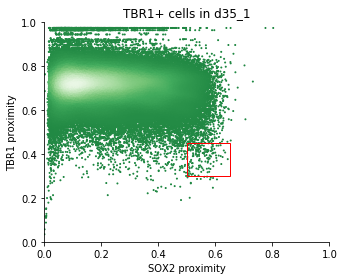

((158, 2), (158,), 158, 0.0009605797524379271)

In [270]:
start = np.asarray([0.5, 0.3])
stop = np.asarray([0.65, 0.45])

show_gate(start, stop)
# plt.savefig(os.path.join(working_dir, 'TBR1_microenvironment_gate_TBR1adj.png'), bbox_inches='tight')
plt.show()

prox_tbr1_gate, idx_gate = apply_gate(start, stop, prox_tbr1)

prox_tbr1_gate.shape, idx_gate.shape, len(idx_gate), len(idx_gate) / len(prox_tbr1)

In [58]:
syto = io.open(os.path.join(org_path, 'dataset/syto.zarr'))
sox2 = io.open(os.path.join(org_path, 'dataset/sox2.zarr'))
tbr1 = io.open(os.path.join(org_path, 'dataset/tbr1.zarr'))

syto.shape

(900, 3790, 3801)

In [59]:
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

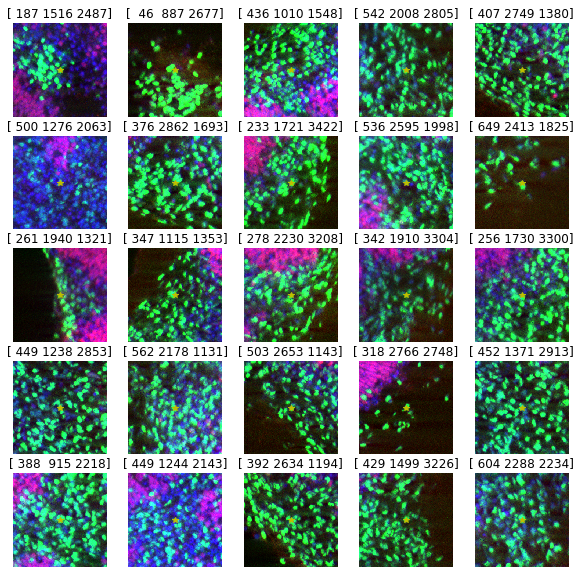

In [66]:
n = 5
width = 256

sample_idx = np.random.choice(np.arange(len(prox_tbr1_gate)), n**2, replace=False)

plt.figure(figsize=(10, 10))
for i in range(n):
    for j in range(n):
        k = j + i*n
        
        p = prox_tbr1_gate[sample_idx[k]]
        loc = idx_tbr1[idx_gate[sample_idx[k]]]
        center = centroids[loc]
        
        roi_start = np.asarray([center[0]-1, center[1] - width//2, center[2] - width//2])
        roi_stop = np.asarray([center[0]+1, center[1] + width//2, center[2] + width//2])
        syto_roi = utils.extract_box(syto, roi_start, roi_stop) 
        sox2_roi = utils.extract_box(sox2, roi_start, roi_stop) 
        tbr1_roi = utils.extract_box(tbr1, roi_start, roi_stop) 
        
        roi = np.dstack([sox2_roi.max(axis=0), tbr1_roi.max(axis=0), syto_roi.max(axis=0)])
        
        plt.subplot(n, n, k+1)
        plt.imshow(roi)
        plt.plot([width//2], [width//2], 'y*')
        plt.title(str(center))
        plt.axis('off')

plt.savefig(os.path.join(working_dir, 'TBR1_microenvironment_TBR1adj.pdf'), bbox_inches='tight')
plt.show()

Check SOX2 microenvironemnts too

In [231]:
# get SOX2+ cells
idx_sox2 = np.where(np.logical_and(labels[:, 0] == 1, labels[:, 1] == 0))[0]
prox_sox2 = proximities[idx_sox2]
len(idx_sox2)

373405

In [232]:
n_points = 10_000
grid_size = 100

prox_sox2_kde = prox_sox2[np.random.choice(np.arange(len(prox_sox2)), n_points)].T
kernel = gaussian_kde(prox_sox2_kde)
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
Z.shape

(100, 100)

In [233]:
f = RegularGridInterpolator(2*(np.linspace(0, 1, 100),), Z)
z = f(prox_sox2)
z.shape

(373405,)

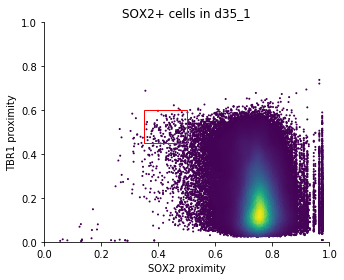

In [234]:
start = np.asarray([0.35, 0.45])
stop = np.asarray([0.5, 0.6])

plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(prox_sox2[:, 0], prox_sox2[:, 1], s=1, c=z, edgecolor=None)
rect = Rectangle(start, stop[0]-start[0], stop[1]-start[1], edgecolor='r', linewidth=1, fill=False)
ax1.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'SOX2+ cells in d35_{org_idx}')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
plt.tight_layout()
sns.despine()
plt.show()

In [235]:
prox_sox2_gate, idx_gate = apply_gate(start, stop, prox_sox2)

prox_sox2_gate.shape, idx_gate.shape

((179, 2), (179,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

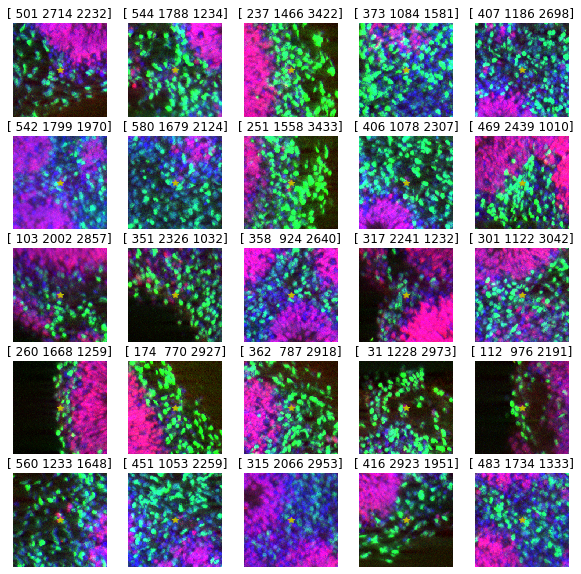

In [75]:
n = 5
width = 256

sample_idx = np.random.choice(np.arange(len(prox_sox2_gate)), n**2, replace=False)

plt.figure(figsize=(10, 10))
for i in range(n):
    for j in range(n):
        k = j + i*n
        
        p = prox_sox2_gate[sample_idx[k]]
        loc = idx_sox2[idx_gate[sample_idx[k]]]
        center = centroids[loc]
        
        roi_start = np.asarray([center[0]-1, center[1] - width//2, center[2] - width//2])
        roi_stop = np.asarray([center[0]+1, center[1] + width//2, center[2] + width//2])
        syto_roi = utils.extract_box(syto, roi_start, roi_stop) 
        sox2_roi = utils.extract_box(sox2, roi_start, roi_stop) 
        tbr1_roi = utils.extract_box(tbr1, roi_start, roi_stop) 
        
        roi = np.dstack([sox2_roi.max(axis=0), tbr1_roi.max(axis=0), syto_roi.max(axis=0)])
        
        plt.subplot(n, n, k+1)
        plt.imshow(roi)
        plt.plot([width//2], [width//2], 'y*')
        plt.title(str(center))
        plt.axis('off')

# plt.savefig(os.path.join(working_dir, 'SOX2_microenvironment_TBR1adj.pdf'), bbox_inches='tight')
plt.show()

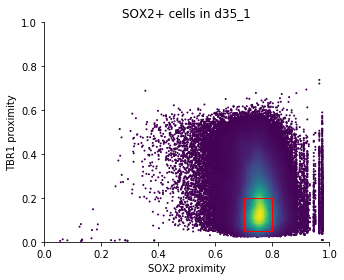

In [236]:
start = np.asarray([0.7, 0.05])
stop = np.asarray([0.8, 0.2])

plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(prox_sox2[:, 0], prox_sox2[:, 1], s=1, c=z, edgecolor=None)
rect = Rectangle(start, stop[0]-start[0], stop[1]-start[1], edgecolor='r', linewidth=1, fill=False)
ax1.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'SOX2+ cells in d35_{org_idx}')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
plt.tight_layout()
sns.despine()
plt.show()

In [237]:
prox_sox2_gate, idx_gate = apply_gate(start, stop, prox_sox2)

prox_sox2_gate.shape, idx_gate.shape

((174245, 2), (174245,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

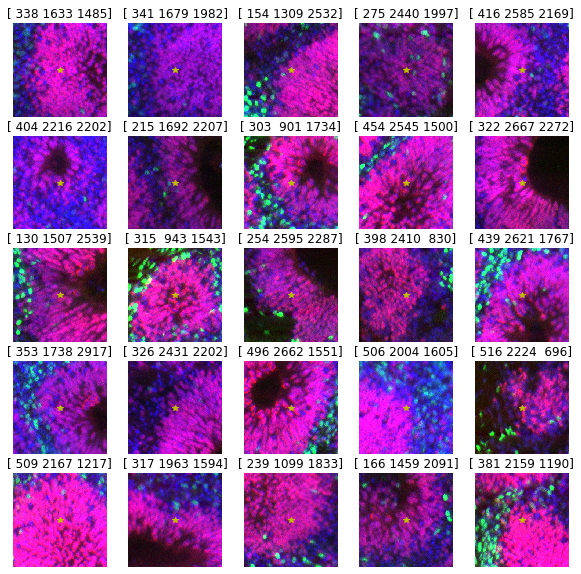

In [80]:
n = 5
width = 256

sample_idx = np.random.choice(np.arange(len(prox_sox2_gate)), n**2, replace=False)

plt.figure(figsize=(10, 10))
for i in range(n):
    for j in range(n):
        k = j + i*n
        
        p = prox_sox2_gate[sample_idx[k]]
        loc = idx_sox2[idx_gate[sample_idx[k]]]
        center = centroids[loc]
        
        roi_start = np.asarray([center[0]-1, center[1] - width//2, center[2] - width//2])
        roi_stop = np.asarray([center[0]+1, center[1] + width//2, center[2] + width//2])
        syto_roi = utils.extract_box(syto, roi_start, roi_stop) 
        sox2_roi = utils.extract_box(sox2, roi_start, roi_stop) 
        tbr1_roi = utils.extract_box(tbr1, roi_start, roi_stop) 
        
        roi = np.dstack([sox2_roi.max(axis=0), tbr1_roi.max(axis=0), syto_roi.max(axis=0)])
        
        plt.subplot(n, n, k+1)
        plt.imshow(roi)
        plt.plot([width//2], [width//2], 'y*')
        plt.title(str(center))
        plt.axis('off')

# plt.savefig(os.path.join(working_dir, 'SOX2_microenvironment_TBR1adj.pdf'), bbox_inches='tight')
plt.show()

Sort SOX2+ cells by TBR1 proximity

In [238]:
idx_sort = np.argsort(prox_sox2[:, 1])
len(idx_sort)

373405

In [239]:
centroids_sox2 = centroids[idx_sox2]
centroids_sox2_sort = centroids_sox2[idx_sort]
prox_sox2_sort = prox_sox2[idx_sort]

centroids_sox2_sort.shape, prox_sox2_sort.shape

((373405, 3), (373405, 2))

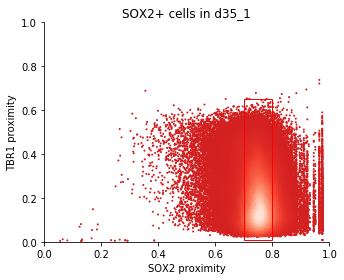

In [246]:
start = np.asarray([0.7, 0.01])
stop = np.asarray([0.8, 0.65])

c = -np.log(z+1e3)
plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(prox_sox2[:, 0], prox_sox2[:, 1], s=1, c=c, edgecolor=None, cmap='Reds', vmin=np.percentile(c, 0)-0.006, vmax=np.percentile(c, 100)+0.02)
rect = Rectangle(start, stop[0]-start[0], stop[1]-start[1], edgecolor='r', linewidth=1, fill=False)
ax1.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'SOX2+ cells in d35_{org_idx}')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join(working_dir, 'SOX2_microenvironment_gate_SOX2adj.png'), bbox_inches='tight')
plt.show()

In [88]:
prox_sox2_gate, idx_gate = apply_gate(start, stop, prox_sox2_sort)

prox_sox2_gate.shape, idx_gate.shape

((289317, 2), (289317,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

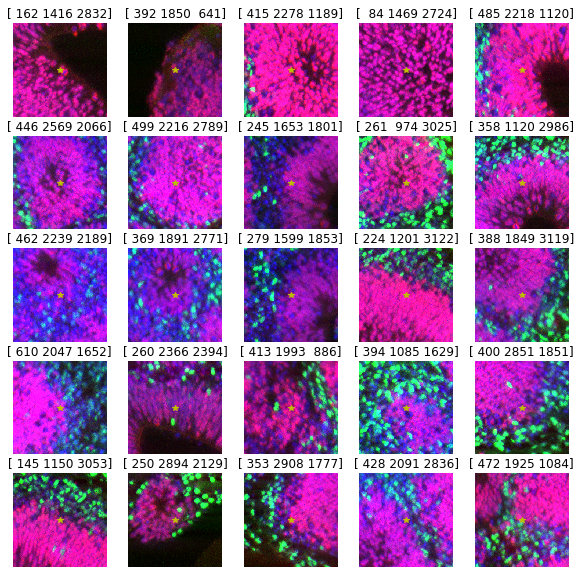

In [89]:
n = 5
width = 256

sample_idx = np.linspace(0, len(idx_gate)-1, n**2).astype(np.int)

plt.figure(figsize=(10, 10))
for i in range(n):
    for j in range(n):
        k = j + i*n
        
        s = sample_idx[k]
        g = idx_gate[s]
        center = centroids_sox2_sort[g]
        
        roi_start = np.asarray([center[0]-1, center[1] - width//2, center[2] - width//2])
        roi_stop = np.asarray([center[0]+1, center[1] + width//2, center[2] + width//2])
        syto_roi = utils.extract_box(syto, roi_start, roi_stop) 
        sox2_roi = utils.extract_box(sox2, roi_start, roi_stop) 
        tbr1_roi = utils.extract_box(tbr1, roi_start, roi_stop) 
        
        roi = np.dstack([sox2_roi.max(axis=0), tbr1_roi.max(axis=0), syto_roi.max(axis=0)])
        
        plt.subplot(n, n, k+1)
        plt.imshow(roi)
        plt.plot([width//2], [width//2], 'y*')
        plt.title(str(center))
        plt.axis('off')

# plt.savefig(os.path.join(working_dir, 'SOX2_microenvironment_SOX2adj.pdf'), bbox_inches='tight')
plt.show()

In [91]:
from sklearn.neighbors import NearestNeighbors

In [109]:
nbrs = NearestNeighbors(n_neighbors=5).fit(prox_sox2_gate)

In [119]:
n = 10

tbr1_min = prox_sox2_gate.min(axis=0)[-1]
tbr1_max = prox_sox2_gate.max(axis=0)[-1]
sox2_mean = prox_sox2_gate.mean(axis=0)[0]

x = np.ones(n) * sox2_mean
y = np.linspace(tbr1_min+0.01, tbr1_max-0.01, n)

In [120]:
x, y

(array([0.75118055, 0.75118055, 0.75118055, 0.75118055, 0.75118055,
        0.75118055, 0.75118055, 0.75118055, 0.75118055, 0.75118055]),
 array([0.03160969, 0.09870282, 0.16579595, 0.23288908, 0.29998221,
        0.36707534, 0.43416847, 0.5012616 , 0.56835473, 0.63544786]))

In [121]:
dists, indices = nbrs.kneighbors(np.vstack([x, y]).T)
indices.shape

(10, 5)

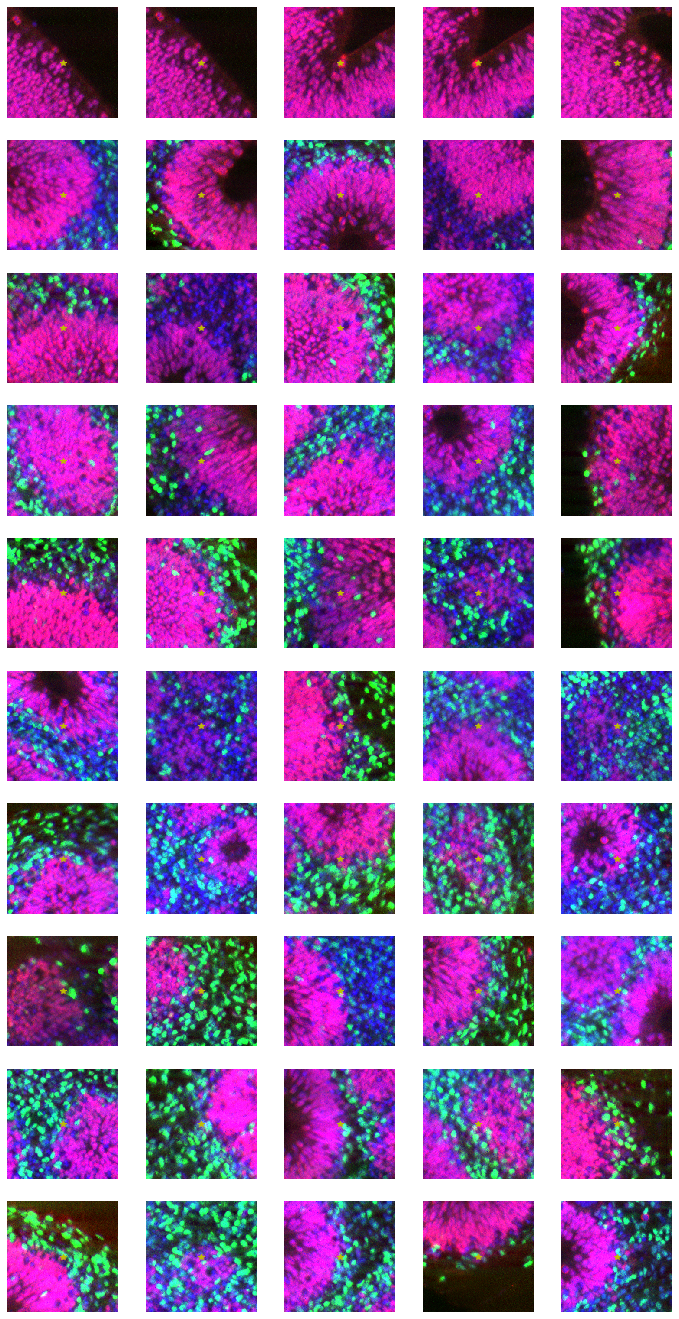

In [125]:
n_cols = 5

plt.figure(figsize=(12, 24))
for i in range(n_cols):
    for j in range(n):
        center = centroids_sox2_sort[idx_gate[indices[j, i]]]
        
        roi_start = np.asarray([center[0]-1, center[1] - width//2, center[2] - width//2])
        roi_stop = np.asarray([center[0]+1, center[1] + width//2, center[2] + width//2])
        syto_roi = utils.extract_box(syto, roi_start, roi_stop) 
        sox2_roi = utils.extract_box(sox2, roi_start, roi_stop) 
        tbr1_roi = utils.extract_box(tbr1, roi_start, roi_stop)         
        roi = np.dstack([sox2_roi.max(axis=0), tbr1_roi.max(axis=0), syto_roi.max(axis=0)])
        roi = np.clip(roi, 0, 1)
        
        plt.subplot(n, n_cols, i + (j*n_cols + 1))
        plt.imshow(roi)
        plt.plot([width//2], [width//2], 'y*')
        plt.axis('off')
    
plt.savefig(os.path.join(working_dir, 'SOX2_microenvironment_TBR1prox_sort.pdf'), bbox_inches='tight')
plt.show()